In [1]:
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#Store Data Variables
import json
with open('feature_data.json', 'r') as f:
 features = json.load(f)

from scipy.io import loadmat
train_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()
query_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()
labels = loadmat('cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
gallery_idxs = loadmat('cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()
filelist = loadmat('cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
camId = loadmat('cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()

In [9]:

X = np.array(features)
y = np.array(labels)
filelist = np.array(filelist)
camId = np.array(camId)



In [10]:
mask_train = np.array(train_idxs).ravel()
mask_query = np.array(query_idxs).ravel()
mask_gallery = np.array(gallery_idxs).ravel()

mask_train = np.subtract(mask_train, 1)
mask_query = np.subtract(mask_query, 1)
mask_gallery = np.subtract(mask_gallery, 1)


X_train, X_query, X_gallery = X[mask_train, :], X[mask_query, :], X[mask_gallery, :]
y_train, y_query, y_gallery = y[mask_train], y[mask_query], y[mask_gallery]
filelist_train, filelist_query, filelist_gallery = filelist[mask_train], filelist[mask_query], filelist[mask_gallery]
camId_train, camId_query, camId_gallery = camId[mask_train], camId[mask_query], camId[mask_gallery]


In [11]:
def get_acc_score(y_valid, y_q, tot_label_occur):
    recall = 0
    true_positives = 0
    
    k = 0
    
    max_rank = 30
    
    rank_A = np.zeros(max_rank)
    AP_arr = np.zeros(11)
    
    while (recall < 1) or (k < max_rank):
        
        if (y_valid[k] == y_q):
            
            true_positives = true_positives + 1
            recall = true_positives/tot_label_occur
            precision = true_positives/(k+1)
            
            AP_arr[round((recall-0.05)*10)] = precision
            
            for n in range (k, max_rank):
                rank_A[n] = 1
            
        k = k+1
        
    max_precision = 0
    for i in range(10, -1, -1):
        max_precision = max(max_precision, AP_arr[i])
        AP_arr[i] = max_precision
    
    AP_ = AP_arr.sum()/11
    
    return AP_, rank_A

In [14]:
from scipy.spatial import distance

def evaluate_metric(X_query, camId_query, y_query, X_gallery, camId_gallery, y_gallery, metric = 'euclidian', parameters = None):

    rank_accuracies = []
    AP = []

    # Break condition for testing
    #q = 0

    for query, camId_q, y_q in zip(X_query, camId_query, y_query):
        q_g_dists = []
        y_valid = []
        for gallery, camId_g, y_g  in zip(X_gallery, camId_gallery, y_gallery):
            if ((camId_q == camId_g) and (y_q == y_g)):
                continue
            else:
                if metric == 'euclidian':
                    dist = distance.euclidean(query, gallery)
                elif metric == 'sqeuclidean':
                    dist = distance.sqeuclidean(query, gallery)
                elif metric == 'seuclidean':
                    dist = distance.seuclidean(query, gallery)
                elif metric == 'minkowski':
                    dist = distance.minkowski(query, gallery, parameters)
                elif metric == 'chebyshev':
                    dist = distance.chebyshev(query, gallery)
                elif metric == 'braycurtis':
                    dist = distance.braycurtis(query, gallery)
                elif metric == 'canberra':
                    dist = distance.canberra(query, gallery)
                elif metric == 'cosine':
                    dist = distance.cosine(query, gallery)
                elif metric == 'correlation':
                    dist = distance.correlation(query, gallery)
                elif metric == 'mahalanobis':
                    dist = distance.mahalanobis(query, gallery, parameters)
                else:
                    raise NameError('Specified metric not supported')           
                q_g_dists.append(dist)
                y_valid.append(y_g)
    
        tot_label_occur = y_valid.count(y_q)
    
        q_g_dists = np.array(q_g_dists)
        y_valid = np.array(y_valid)
    
        _indexes = np.argsort(q_g_dists)
    
        # Sorted distances and labels
        q_g_dists, y_valid = q_g_dists[_indexes], y_valid[_indexes]
        
        if tot_label_occur != 0:
    
            AP_, rank_A = get_acc_score(y_valid, y_q, tot_label_occur)

            AP.append(AP_)

            rank_accuracies.append(rank_A)
    
        #if q  > 5:
        #    break
        #q = q+1

    rank_accuracies = np.array(rank_accuracies)

    total = rank_accuracies.shape[0]
    rank_accuracies = rank_accuracies.sum(axis = 0)
    rank_accuracies = np.divide(rank_accuracies, total)

    i = 0
    print ('Accuracies by Rank:')
    while i < rank_accuracies.shape[0]:
        print('Rank ', i+1, ' = %.2f%%' % (rank_accuracies[i] * 100), '\t',
              'Rank ', i+2, ' = %.2f%%' % (rank_accuracies[i+1] * 100), '\t',
              'Rank ', i+3, ' = %.2f%%' % (rank_accuracies[i+2] * 100), '\t',
              'Rank ', i+4, ' = %.2f%%' % (rank_accuracies[i+3] * 100), '\t',
              'Rank ', i+5, ' = %.2f%%' % (rank_accuracies[i+4] * 100))
        i = i+5

    AP = np.array(AP)

    mAP = AP.sum()/AP.shape[0]
    print('mAP = %.2f%%' % (mAP * 100))
    
    return rank_accuracies, mAP

    
        
    

In [15]:
# Baseline Euclidian
rank_accuracies, mAP = evaluate_metric(X_train, camId_train, y_train,
                                       X_train, camId_train, y_train,
                                       metric ='euclidian',
                                       parameters = None)



Accuracies by Rank:
Rank  1  = 99.82% 	 Rank  2  = 99.86% 	 Rank  3  = 99.88% 	 Rank  4  = 99.89% 	 Rank  5  = 99.89%
Rank  6  = 99.90% 	 Rank  7  = 99.90% 	 Rank  8  = 99.92% 	 Rank  9  = 99.92% 	 Rank  10  = 99.92%
Rank  11  = 99.92% 	 Rank  12  = 99.92% 	 Rank  13  = 99.93% 	 Rank  14  = 99.93% 	 Rank  15  = 99.95%
Rank  16  = 99.96% 	 Rank  17  = 99.96% 	 Rank  18  = 99.96% 	 Rank  19  = 99.97% 	 Rank  20  = 99.97%
Rank  21  = 99.97% 	 Rank  22  = 99.97% 	 Rank  23  = 99.97% 	 Rank  24  = 99.97% 	 Rank  25  = 99.99%
Rank  26  = 99.99% 	 Rank  27  = 99.99% 	 Rank  28  = 99.99% 	 Rank  29  = 99.99% 	 Rank  30  = 99.99%
mAP = 99.79%


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


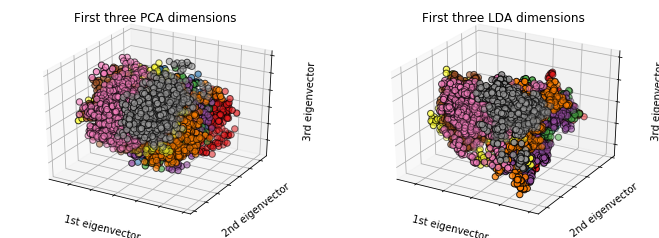

In [20]:
# Graphing training set

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1, 2, 1, projection='3d')

#fig = plt.figure(1, figsize=(8, 6))
#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X_train)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_train.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(1, 2, 2, projection='3d')

#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = LinearDiscriminantAnalysis(n_components=3).fit_transform(X_train, y_train.ravel())
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_train.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three LDA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])


plt.show()

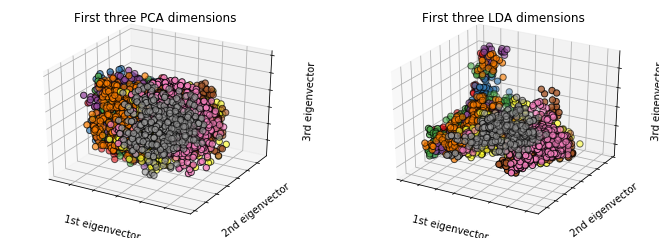

In [21]:
# Graphing gallery set

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1, 2, 1, projection='3d')

#fig = plt.figure(1, figsize=(8, 6))
#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X_gallery)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_gallery.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(1, 2, 2, projection='3d')

#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = LinearDiscriminantAnalysis(n_components=3).fit_transform(X_gallery, y_gallery.ravel())
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_gallery.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three LDA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])


plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


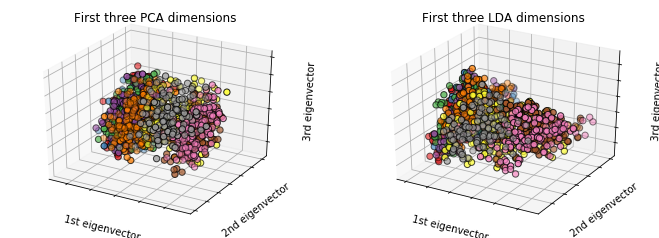

In [22]:
# Graphing query set

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1, 2, 1, projection='3d')

#fig = plt.figure(1, figsize=(8, 6))
#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X_query)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_query.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

ax = fig.add_subplot(1, 2, 2, projection='3d')

#ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = LinearDiscriminantAnalysis(n_components=3).fit_transform(X_query, y_query.ravel())
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_query.ravel(),
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three LDA dimensions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])


plt.show()